In [122]:
import sys
sys.path.append(r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project')
from execute_remote_scripts import *
%matplotlib widget
import matplotlib.pyplot as plt
import random
%load_ext autoreload
%autoreload 2

from Processing_Data.EDA import *
from Processing_Data.create_labels import * # To load the data in dictionaries

# Enable LaTeX rendering
plt.rcParams.update({
    "text.usetex": False, 
    "font.family": "serif"
})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
# Loading classified shots in dictionaries
base_path = r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\CSV_Files'
re_autom_path = r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Data\automatic_RE_numbers.csv'
re_valid_path = r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Data\validated_RE_numbers.csv'

dataframes, RE_autom, RE_valid, NO_RE_probably, features = load_and_process_data(
    base_path, re_autom_path, re_valid_path, check_nans_infs
)

# Print results
print(f"Loaded {len(dataframes)} shots.")
print(f"Automatic RE shots: {len(RE_autom)}")
print(f"Validated RE shots: {len(RE_valid)}")
print(f"Probably NO RE shots: {len(NO_RE_probably)}")
print(f"Features: {features}")

DataFrame 100055: NaNs = 1134, Infs = 0
DataFrame 100057: NaNs = 4, Infs = 0
DataFrame 100059: NaNs = 253, Infs = 0
DataFrame 100078: NaNs = 1918, Infs = 0
DataFrame 100130: NaNs = 1499, Infs = 0
DataFrame 100131: NaNs = 1007, Infs = 0
DataFrame 100133: NaNs = 275, Infs = 0
DataFrame 100488: NaNs = 1440, Infs = 0
DataFrame 83333: NaNs = 1097, Infs = 0
DataFrame 83432: NaNs = 4483, Infs = 0
DataFrame 83433: NaNs = 3814, Infs = 0
DataFrame 83435: NaNs = 4829, Infs = 0
DataFrame 83438: NaNs = 2906, Infs = 0
DataFrame 83497: NaNs = 416, Infs = 0
DataFrame 83544: NaNs = 3012, Infs = 0
DataFrame 83572: NaNs = 4340, Infs = 0
DataFrame 83575: NaNs = 6000, Infs = 0
DataFrame 83601: NaNs = 7050, Infs = 0
DataFrame 83619: NaNs = 1538, Infs = 0
DataFrame 83635: NaNs = 2364, Infs = 0
DataFrame 84158: NaNs = 482, Infs = 0
DataFrame 84160: NaNs = 1395, Infs = 0
DataFrame 84162: NaNs = 832, Infs = 0
DataFrame 84164: NaNs = 808, Infs = 0
DataFrame 84167: NaNs = 365, Infs = 0
DataFrame 84553: NaNs = 472

In [124]:
random.seed(42) # So that we always work with the same ones.
random_50_re = random.sample(RE_valid, 50)  # Ensures no duplicates

In [91]:
# #In case we need to recreate the dictionary
# RE_lifetimes = {}

# np.savez(r"C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Processing_Data\RE_lifetime.npz", **RE_lifetimes)


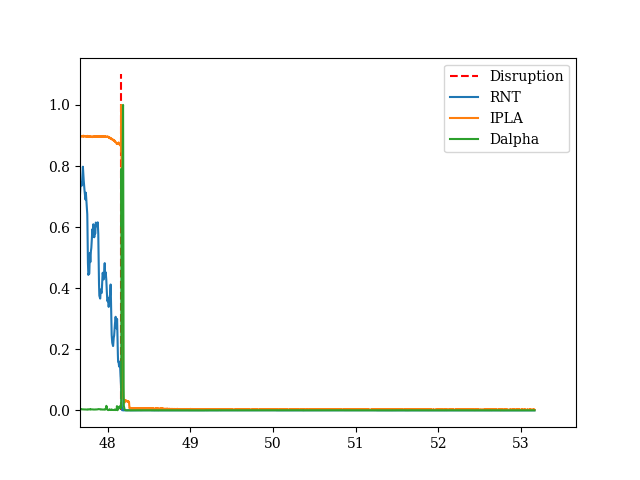

98083


In [213]:
# Shot that is currently processed
k = 19
shot_nr = random_50_re[k]
if str(shot_nr) in list(RE_lifetimes.keys()):
    print('Stop, you are about to redo work!')
    print('\n'*50)

# Load the file and plot it
file_path = os.path.join(base_path, 'JETno' + str(shot_nr)+'.csv')
data = pd.read_csv(file_path)
plt.close()

# Find the first index where time is greater than the starting time + 1
first_index = np.argmax(data['time'] > data['time'][0] + 1)  

# Plot vertical line at this point
plt.vlines(data['time'][first_index], ymin=0, ymax=1.1, color='r', linestyle='dashed', label='Disruption')

#plt.plot(data['time'], data['SSXcore'] /max(data['SSXcore']), label='SSX')
plt.plot(data['time'], data['RNT'] /max(data['RNT']), label='RNT')
plt.plot(data['time'], -data['IPLA'] / max(-data['IPLA']), label='IPLA')
plt.plot(data['time'], -data['DAI_EDG7'] / -max(data['DAI_EDG7']), label='Dalpha')

# Show the plot
plt.legend()
plt.xlim(data['time'][first_index]-0.5, data['time'][first_index]+5.5)
plt.show()

print(shot_nr)

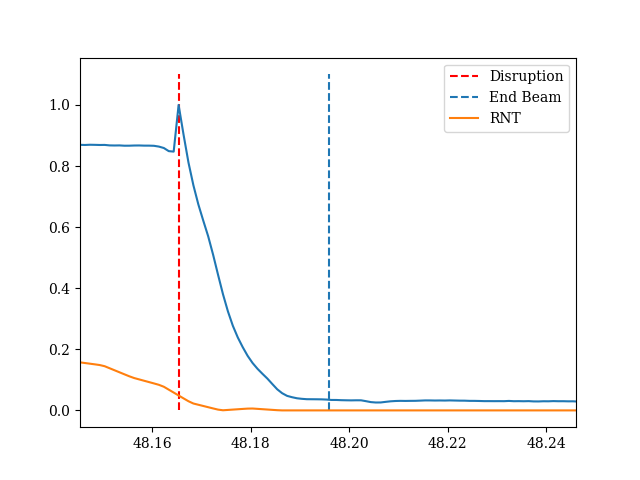

98083


In [214]:
# Set time that is to be written as end of the beam time
end_beam = 48.1960

# Setting shot number again in case I did something weird in between
shot_nr = random_50_re[k]

# Load the dictionary
RE_lifetimes = np.load(r"C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Processing_Data\RE_lifetime.npz")
RE_lifetimes = {key: RE_lifetimes[key] for key in RE_lifetimes.files}
# Set the new value and save
RE_lifetimes[f'{shot_nr}'] = np.array([data['time'][first_index], end_beam])
np.savez(r"C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Processing_Data\RE_lifetime.npz", **RE_lifetimes)

# Plot to verify
plt.close()
plt.vlines(data['time'][first_index], ymin=0, ymax=1.1, color='r', linestyle='dashed', label='Disruption')
plt.vlines(end_beam, ymin=0, ymax=1.1, linestyle='dashed', label='End Beam')
plt.plot(data['time'], -data['IPLA']/max(-data['IPLA']))
plt.plot(data['time'], data['RNT'] /max(data['RNT']), label='RNT')

# Show the plot
plt.legend()
plt.xlim(data['time'][first_index]-0.02, end_beam+0.05)
plt.show()
print(shot_nr)

In [207]:
RE_lifetimes

{'98173': array([56.07429912, 56.09      ]),
 '91076': array([60.0238, 60.105 ]),
 '98088': array([56.5092, 56.535 ]),
 '97085': array([53.8901, 53.917 ]),
 '97081': array([51.8327, 51.86  ]),
 '98153': array([48.0242, 50.68  ]),
 '90037': array([61.5411, 61.59  ]),
 '85947': array([60.01979912, 60.05      ]),
 '91888': array([47.4401, 47.47  ]),
 '91355': array([52.0026, 52.035 ]),
 '90600': array([56.7403, 56.772 ]),
 '89261': array([52.0429, 52.506 ]),
 '98477': array([50.5159, 50.537 ]),
 '97477': array([49.4788, 49.5911]),
 '87940': array([60.0236, 60.137 ]),
 '98066': array([55.0982, 55.122 ]),
 '96070': array([50.7108, 50.867 ]),
 '85978': array([60.0203, 60.042 ]),
 '85948': array([60.0199, 60.0495]),
 '87941': array([60.0247, 60.1055]),
 '91081': array([60.0248, 60.0671])}

## Creating targets from beam durations

In [106]:
save_path_targets = r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\CSV_targets'
targets = save_re_targets(RE_lifetimes, base_path, save_path_targets)

targets_no_re = save_no_re_targets(NO_RE_probably, base_path, save_path_targets)

True False


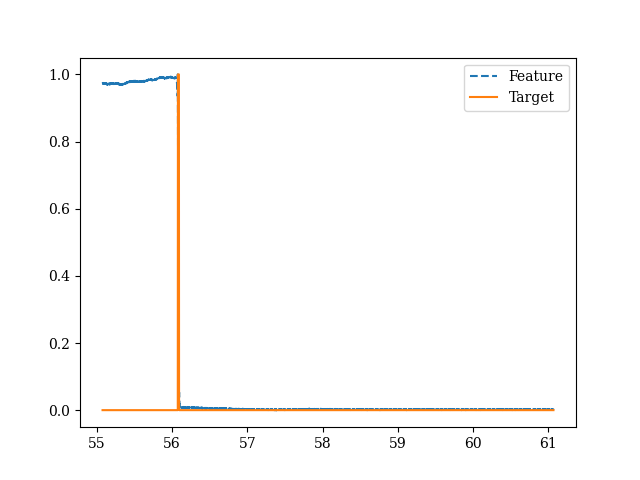

In [121]:
# Plot for verification
shot_nr = os.listdir(save_path_targets)[random.randint(0, len(os.listdir(save_path_targets)))].split('.')[0].split('no')[1]

# Load the file and plot it
feature_path = os.path.join(base_path, 'JETno' + str(shot_nr)+'.csv')
target_path = os.path.join(save_path_targets, 'JETno' + str(shot_nr)+'.csv')
feature = pd.read_csv(feature_path)
target = pd.read_csv(target_path)

plt.close()
plt.plot(feature['time'], -feature['IPLA'] /max (-feature['IPLA']), '--', label='Feature')
plt.plot(feature['time'], target['target'], label='Target')
plt.legend()
print(int(shot_nr) in RE_valid, int(shot_nr) in NO_RE_probably)

In [59]:
dict = {'a': 1, 'b': 2}

for x, y in dict.items():
    print(x, y)

a 1
b 2


In [86]:
max(target['target'])

1.0

In [88]:
feature['time'][target['target']==1]

1002    60.0248
1003    60.0258
1004    60.0268
1005    60.0278
1006    60.0288
         ...   
1083    60.1058
1084    60.1068
1085    60.1078
1086    60.1088
1087    60.1098
Name: time, Length: 86, dtype: float64